# Librerías y definición de funciones

In [22]:
import os
import numpy as np
import nibabel as nib
import random
from dipy.io.streamline import load_tractogram
from dipy.tracking.streamline import Streamlines
from dipy.segment.clustering import QuickBundles
from dipy.segment.metric import IdentityFeature
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from dipy.io.pickles import save_pickle
from dipy.io.pickles import load_pickle
from dipy.data import get_fnames
from dipy.viz import window, actor
import time
import utils.bundleTools as bt
import utils.bundleTools3 as bt3

def display(streamlines, clusters=False, ids=False, hd=False, color = 'tab20'):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    if(clusters):
        colormap = actor.create_colormap(np.arange(len(ids)), name=color, auto=True)
        #colormap = actor.create_colormap(np.arange(int(len(ids)/2)+1), name='tab20', auto=True)
        #colormap = [*colormap[:-1],*colormap[:-1], colormap[-1]]

        stream = []
        colors = []

        for i,id_ in enumerate(ids):
            for streamline in clusters[id_]:
                stream.append(streamlines[streamline])
                colors.append(colormap[i])#*len(streamlines[streamline]))
        if(hd):
            ren.add(actor.streamtube(stream, linewidth=0.1, colors=colors))
        else:
            ren.add(actor.line(stream, colors))
            
    else:
        if(hd):
            #ren.add(actor.line(streamlines, window.colors.black, opacity=0.05))
            ren.add(actor.streamtube(streamlines, linewidth=0.1, colors=[(0.4,0.698,1)]*len(streamlines)))
        else:
            ren.add(actor.line(streamlines))

    window.show(ren, size=(1200, 900))
    
byte_order = "DCBA"

def get_centroids(brain, sub, remove_little_ones=False, size=False, nearest=False):
    # remove_little_ones: Cantidad mínima de fibras por cluster (para eliminar clusters poco densos). 
    # size: Distancia mínima entre los dos primeros puntos del centroide (para eliminar fibras muy cortas).
    # nearest: Sólo se selecciona un nearest% (porcentaje) aleatorio de las fibras del cluster (para disminuir la carga computacional).
    
    centroids = []
    original_data = []
    
    og_centroids = np.array(bt3.read_bundle_severalbundles(path + sub + '/Talairach/centroids_Tal.bundles')[0])
    
    if(remove_little_ones):
        removed1 = 0
        removed2 = 0
        for i,cluster in enumerate(brain):
            sz = len(cluster)
            if(sz >= remove_little_ones):
                centroid = og_centroids[i][0]
                if np.linalg.norm(centroid[0]-centroid[1]) > size:
                    centroids.append(centroid)
                    selected = random.sample(range(sz),int(sz*(nearest/100)))
                    original_data.append(np.array(cluster)[selected])
                else:
                    removed2 +=1
            else:
                removed1+=1
        print(str(removed1)+' and '+str(removed2)+' removed from '+str(len(brain))+'. '+str(len(centroids))+' remaining centroids.'+str(len(np.concatenate(brain)))+' remaining fibers')
    else:
        for cluster in brain:
            centroids.append(get_centroid(cluster))
            original_data.append(np.array(cluster))
    return centroids, np.array(original_data)

def random_palette(n):
    return [(random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255)) for i in range(n)]

def write_hie(path,names,colors):
    f = open(path,"w")
    f.write("# tree 1.0\n\n*BEGIN TREE hierarchy\ngraph_syntax RoiArg\n\n*BEGIN TREE fold_name\nname ALL\n\n")
    for i,n in enumerate(names):
        f.write("*BEGIN TREE fold_name\n")
        f.write("name "+n+"\n")
        f.write("color "+str(colors[i][0])+" "+str(colors[i][1])+" "+str(colors[i][2])+"\n\n")
        f.write("*END\n\n")
    f.write("*END\n\n*END\n\n*END\n\n")
    f.close()


def write_header(path,bnames,intervals,dim,nfibers):
    f = open(path,"w")
    f.write("attributes = {\n    'binary' : 1,\n    'bundles' : ")
    f.write(str([val for pair in zip(bnames, intervals) for val in pair])+",\n")
    f.write("    'byte_order' : "+'\''+byte_order+'\',\n')
    f.write("    'curves_count' : "+str(nfibers)+",\n")
    f.write("    'data_file_name' : "+"\'*"+os.path.splitext(path+"data")[1]+"\',\n")
    f.write("    'format' : 'bundles_1.0',\n")
    f.write("    'space_dimension' : "+str(dim)+"\n  }")
    f.close()

def write_data(data_path,bundles,dim):
    f = open(data_path,"wb")
    for b in bundles:
        for fiber in b:
            f.write(np.array([len(fiber)],dtype=np.int32).tostring())
            f.write(fiber.ravel().tostring())
    f.close()

def write_bundles(path,bundles,bnames=None,colors=None):
    if bnames == None:
        bnames = [''+str(i)+'' for i in range(len(bundles))]
    bnames = [''+n.strip()+'' for n in bnames]
    data_path = path+"data"
    dim = len(bundles[0][0][0])
    nfibers = sum(len(b) for b in bundles)
    intervals = [0]
    for i in range(1,len(bundles),1):
        intervals.append(intervals[i-1]+len(bundles[i-1])) 

    write_header(path,bnames,intervals,dim,nfibers)
    write_data(data_path,bundles,dim)
    if colors == None:
        colors = random_palette(len(bnames))
    write_hie(os.path.splitext(path)[0]+".hie",bnames,colors)

In [7]:
import utils.bundleTools3 as bt3

centroids = []

for i in range(1,80):
    centroids.append([])

In [8]:
for i in range(len(intra_centroids)):
    to = ids[i] - 1
    
    centroids[to].append(intra_centroids[i])

In [50]:
lista = []

for i in range(1,80):
    lista.append(str(i))

In [52]:
bt3.write_bundle_severalbundles('all_centroids_2.bundles', centroids, lista)

# Clustering ínter-sujeto con QuickBundles

__Guardado de datos en archivos .npy__

In [ ]:
# Directorio con clusters intra-sujeto calculados con FFClust
path = 'data/79subjects/clustered_2/'

all_centroids = []    #Arreglo que contiene todos los centroides
all_data = []         #Arreglo que contiene todas las fibras
ids = []              #Arreglo que contiene todos los identificadores (a qué sujeto pertenece cada cluster)

for i in range(1,80): #Iteración sobre todos los sujetos
    
    #Se asume que los sujetos están en carpetas desde "001" hasta "079"
    if i < 10:
        name = '00' + str(i)
    else:
        name = '0' + str(i)
    
    #Lectura de clusters
    data = np.array(bt3.read_bundle_severalbundles(path + name + '/Talairach/finalClusters_tal.bundles')[0])
    
    #Obtención de fibras y centroides, y guardado en arreglos
    centroids, data = get_centroids(data, name, 15, 1.5, 100)   #En definición de get_centroids se explican los parámetors
    all_centroids.append(centroids)
    all_data.append(data)
    
    #Cálculo de identificadores
    ids += [i]*len(data)
    
print('Saving all_data...')

#Guardado de fibras, centroides, e ids en archivos .npy (optimizado para arreglos numpy)
np.save(path+'filtered/all_centroids', np.concatenate(all_centroids))
np.save(path+'filtered/ids', np.array(ids))
# np.save(path+'filtered/all_data', np.concatenate(all_data))

__Carga de datos de clustering intra-sujeto__

In [4]:
#Path para almacenar los clusters filtrados
data_path = 'data/79subjects/clustered_2/filtered/'

In [8]:
#Carga de identificadores => elemento i indica a qué sujeto pertenece el centroide i.
ids = np.load(data_path + 'ids.npy')

#Carga de centroides intra-sujeto y conversión a ArraySequence (AS, formato utilizado por DIPY/QuickBundles)
intra_centroids = np.load(data_path + 'all_centroids.npy')
intra_centroids_AS = nib.streamlines.ArraySequence(intra_centroids)

#Arreglo de fibras...
fibers = np.empty((0))

#...se cargan en batches para disminuir uso de memoria
for i in range(1,9):
    new_data = np.load(data_path + 'all_data_' + str(i) + '.npy', allow_pickle = True)
    for j in range(len(new_data)):
        fibers = np.concatenate((fibers,new_data[j]))

__Clustering de centroides con QuickBundles__

In [9]:
#Tiempos:

#theta = 30 => time = 39.125555753707886 [s]
#theta = 25 => time = 82.16234850883484 [s]
#theta = 20 => time = 196.0322229862213 [s]
#theta = 15 => time = 562.9691634178162 [s]
#theta = 10 => time = 2748.397008419037 [s]

In [64]:
#Como las fibras ya están muestreadas con 21 puntos, se evita el resampleo interno de QB...
feature = IdentityFeature()
metric = AveragePointwiseEuclideanMetric(feature=feature)

#Umbral de distancia de QB en mm (notar que debe ser un float)
theta = 20.

#Creación de método QB
qb = QuickBundles(threshold = theta, metric = metric)

#Clustering
t0 = time.time()
inter_clusters = qb.cluster(intra_centroids_AS)
print('Tiempo: ' + str(time.time() - t0) + ' [s]')

#Guardado de clustering en pkl
save_pickle(data_path + 'centroids_QB_' + str(theta)[0:-2] + 'mm.pkl', inter_clusters)

Tiempo: 186.69596147537231 [s]


QB crea un arreglo (inter_clusters) en donde cada elemento es un cluster con atributos, como los índices de las fibras originales pertenecientes a el, y su correspondiente centroide, entre otros.

__Carga de clustering__

In [5]:
theta = 20.
inter_clusters = load_pickle(data_path + 'centroids_QB_' + str(int(theta)) + 'mm.pkl')

__Resumen del clustering inter-sujeto__

In [6]:
print("No. clusters:", len(inter_clusters))
print("Streamlines indices of the first cluster:\n", inter_clusters[0].indices)
print("Centroid of the last cluster:\n", inter_clusters[-1].centroid)

No. clusters: 1429
Streamlines indices of the first cluster:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 640, 1099, 1101, 1105, 1106, 1107, 1109, 1110, 1111, 1112, 1113, 1451, 1552, 1563, 1564, 1565, 1778, 1779, 1780, 1781, 1782, 1783, 1803, 9329, 9330, 9331, 9332, 9333, 9334, 9335, 9336, 9337, 9338, 9339, 9340, 9342, 9343, 9344, 9345, 9346, 9347, 9349, 9350, 9351, 9352, 9353, 9357, 9360, 9726, 9732, 9748, 9806, 9815, 9823, 9835, 9842, 9857, 10391, 10412, 11008, 13277, 18914, 18915, 18916, 18917, 18918, 18919, 18921, 18927, 18929, 18933, 18934, 18935, 18936, 18937, 18938, 18940, 18941, 18942, 18944, 18947, 18949, 18952, 18953, 18956, 18957, 18958, 19070, 19071, 19072, 19073, 19074, 19075, 19080, 19081, 19083, 19084, 19085, 19086, 19087, 19088, 19089, 19090, 19091, 19095, 19498, 19509, 19512, 19785, 19787, 19794, 19801, 19803, 19818, 20127, 29031, 29032, 29033, 29034, 29035, 29036, 29037, 29038, 29039, 29040, 29041, 29042, 29043, 29044, 29045, 29046, 29047, 2

__Visualización de cluster inter-sujeto con aportes de cada sujeto__

Este bloque grafica los $N_s$ centroides que componen un cluster ínter-sujeto en una imagen, y también obtiene $N_s$ imágenes de los clusters correspondientes a dichos centroides. Estas imágenes son guardadas en un directorio.

Cabe destacar que sólo se obtienen imagénes de clusters con $N_s > subs\_thr$, donde $subs\_thr$ es un umbral definido.

In [25]:
for z in range(len(inter_clusters)):
    #Número de cluster a visualizar
    idx = z

    #Umbral de sujetos (sólo considerar aquellos clusters formados por fibras de más de subs_thr sujetos)
    subs_thr = 70

    #Indices de centroides intra-sujeto correspondientes al cluster
    cluster_idx = inter_clusters[idx].indices

    #Centroides correspondientes al cluster
    inter_cluster = intra_centroids_AS[cluster_idx]

    #Identificadores de centroides correspondientes al cluster
    clusters_ids = ids[cluster_idx]

    #Paleta de colores (1 por sujeto)
    colormap = actor.create_colormap(np.arange(len(set(clusters_ids))))

    #Mapa de colores (1 por centroide)
    colormap_full = np.ones((len(inter_cluster), 3))

    #Se asigna el mismo color a centroides que vienen del mismo sujeto
    for sub, color in zip(set(clusters_ids), colormap):
        colormap_full[np.where(clusters_ids == sub)] = color*10

    #True: Guardar imágenes en disco y también visualizar clusters aquí.
    #False: Sólo guardar en disco.
    interactive = False

    #Creación de directorio donde se guardarán las imágenes
    if not os.path.exists('images_QB_' + str(int(theta)) + '/' + str(idx)):
        os.makedirs('images_QB_' + str(int(theta)) + '/' + str(idx))

    
    #Creación de escena y parámetros de figura
    ren = window.Scene()
    window.Scene().clear
    
    #Fondo blanco
    ren.SetBackground(1, 1, 1)
    
    #Creación de objetos fibras (streamlines) para los centroides que componen el cluster ínter-sujeto
    ren.add(actor.streamtube(inter_cluster, colormap_full, linewidth = 0.2))
    
    #Definición de cámara (lamentablemente no pude obtener un buen ángulo de visualización que funcione para todos los clusters)
    ren.set_camera(position=(-4.04,270.91,101.11),focal_point=(0.64,52.22,-50.08),view_up=(0.01,0.57,-0.82))
    
    #Guardado de imagen en disco.
    window.snapshot(ren, size=(1920,1080), fname='images_QB_' + str(int(theta)) + '/' + str(idx) + '/inter-cluster.png')
    # window.record(ren, size=(800, 600), n_frames = 10, path_numbering = True, stereo = 'interlaced', verbose = True)
    if interactive:
        window.show(ren, reset_camera = False)

    camara = ren.get_camera()

    #Lista de sujetos que componen al cluster
    subs = list(set(ids[inter_clusters[idx].indices]))

    masks = []
    
    #Obtención de las fibras que pertenecen a cada centroide intra-sujeto.
    if len(subs) >= subs_thr:
        for indice, sub in enumerate(subs):
            a = np.array(inter_clusters[idx].indices)
            mask = np.array(ids[inter_clusters[idx].indices] == sub)
            centroids = a[mask]

            temp = np.empty([0,21,3])
            temp_centroid = np.empty([0,21,3])

            for centroid in centroids:
                temp = np.append(temp, fibers[centroid], axis = 0)
                temp_centroid = np.append(temp_centroid, intra_centroids_AS[centroid].reshape([1,21,3]), axis = 0)

            ren = window.Scene()
            window.Scene().clear
            ren.SetBackground(1, 1, 1)
            ren.add(actor.streamtube(temp, np.tile(colormap[indice]*10, len(temp)).reshape(len(temp),3), linewidth = 0.1, opacity = 0.05))
            ren.add(actor.streamtube(temp_centroid, np.tile(colormap[indice]*10, len(temp_centroid)).reshape(len(temp_centroid),3), linewidth = 0.2))
            ren.set_camera(position=camara[0],focal_point=camara[1],view_up=camara[2])
            window.snapshot(ren, size=(1920,1080), fname='images_QB_' + str(int(theta)) + '/' + str(idx) + '/' + str(sub) + '.png')

    else:
        print("Cantidad de sujetos insuficiente!")

KeyboardInterrupt: 

__Representatividad del clustering ínter-sujeto__

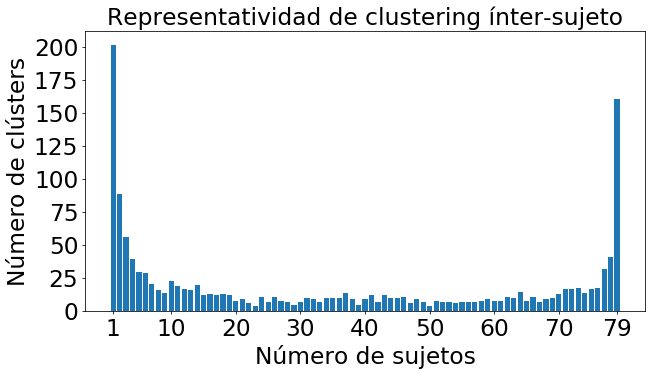

In [21]:
#Arreglo para almacenar la cantidad de sujetos que componen cada cluster.
represent = []

for cluster in inter_clusters:
    
    subs = len(set(ids[cluster.indices]))     #Cantidad de ids únicos que aparecen en el cluster ínter-sujeto.
    
    represent.append(subs)

represent = np.array(represent)

#Creación de histograma
hist = [0]*79

for i in range(0,79):
    hist[i] = np.sum(represent == i+1)

#Gráfico del histograma
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,4), dpi = 70)
ax = fig.add_axes([0,0,1,1])
ax.bar(range(1,80), hist[:])

plt.xlabel('Número de sujetos', fontsize = 24)
plt.xticks([1,10,20,30,40,50,60,70,79], fontsize = 24)
plt.yticks(fontsize = 24)
plt.ylabel('Número de clústers', fontsize = 24)
plt.title('Representatividad de clustering ínter-sujeto', fontsize = 24)

#Guardado de figura
fig.savefig('data/79subjects/inter-clustered_QB_' + str(int(theta)) + '2/represent.pdf', dpi = 300, bbox_inches = 'tight')

__Filtrado de clusters por cantidad de sujetos que lo componen__

In [74]:
keys = range(1,80)  #De 1 hasta 79 (sujetos).

#Diccionarios que almacenan los clusters, nombre de clusters, y centroides para cada sujeto.
subs_clusters = {key: [] for key in keys}
subs_centroids = {key: [] for key in keys}
subs_clusters_names = {key: [] for key in keys}

#Umbral mínimo de representatividad (cantidad mínima de sujetos distintos que componen el cluster).
subs_thr = 70

#Índices de clusters ínter-sujeto que superan el umbral de representatividad.
qb_valid_idx = []

#Para cada cluster ínter-sujeto...
for j, cluster in enumerate(inter_clusters):
    
    #Sujetos únicos que lo componen
    subs = set(ids[cluster.indices])
    
    #Si la cantidad de sujetos no supera el umbral, descartar el cluster. De lo contrario seguir.
    if len(subs) < subs_thr:
        print(j)
        continue
    
    #Se guarda el índice del cluster válido.
    qb_valid_idx.append(j)
    
    #Para cada uno de los sujetos que componen el cluster...
    for sub in subs:
        #Se guarda el nombre del cluster, basado en el índice relativo a los clusters obtenidos con QB.
        subs_clusters_names[sub].append('cluster_' + str(j))
    
    #Se crean diccionarios temporales para cada sujeto que compone el cluster, una para las fibras y otra para los centroides.
    subs_temp = {key: [] for key in subs}
    subs_centroid_temp = {key: [] for key in subs}
    
    #Para cada índice (centroide intra-sujeto) que contiene el cluster...
    for idx in cluster.indices:
        #Se guarda el centroide en la lista de centroides, en el elemento correspondiente al sujeto que originó el centroide.
        subs_centroid_temp[ids[idx]].append(intra_centroids_AS[idx])
        
        #Se hace lo mismo para las fibras que componen el cluster intra-sujeto asociadas al centroide intra-sujeto.
        for fiber in fibers[idx]:
            subs_temp[ids[idx]].append(fiber)

    #Finalmente, se guardan los diccionarios temporales en diccionarios definitivos.
    for sub in subs_temp.keys():
        if subs_centroid_temp[sub] != []:
            subs_centroids[sub].append(subs_centroid_temp[sub])
        if subs_temp[sub] != []:
            subs_clusters[sub].append(subs_temp[sub])

3
14
25
31
32
37
48
49
52
53
54
66
75
78
81
82
85
94
97


KeyboardInterrupt: 

Diccionarios:
 
_subs\_centroids_ : La llave (de 1 a 79) corresponde a cada sujeto. El valor de cada una es una lista, donde cada elemento es también una lista, que corresponde al conjunto de centroides intra-sujeto (obtenidos con FFClust) que fueron agrupados en un mismo cluster ínter-sujeto por QuickBundles.

_subs\_clusters_ : Lo mismo que el anterior, pero en lugar de centroides, guarda las __fibras__ asociadas a cada uno de los centroides que fueron agrupados en un mismo cluster ínter-sujeto por QB.

_subs\_clusters_names_ : Nuevamente cada llave corresponde a un sujeto. Sin embargo, el valor asociado es una lista, en donde el $i$-ésimo elemento indica a que cluster ínter-sujeto pertenece el $i$-ésimo conjunto de centroides/fibras que fueron agrupadas por QB (las que se encuentran en los dos primeros diccionarios).

__Número de fibras/centroides intra-sujetos restantes.__

In [54]:
cuales = []
n_intra_centroids = 0
n_intra_fibers = 0

for idx, cluster in enumerate(inter_clusters):
    n_subs = len(set(ids[cluster.indices]))
    
    if n_subs >= 70:
        cuales.append(idx)
        n_intra_centroids += len(cluster.indices)
        for j in range(len(fibers[cluster.indices])):
            n_intra_fibers += len(fibers[cluster.indices][j])

In [55]:
print('Quedan ' + str(n_intra_centroids) + ' centroides intra-sujeto,')
print('Asociados a ' + str(n_intra_fibers) + ' fibras intra-sujeto.')

Quedan 611534 centroides intra-sujeto,
Asociados a 33093801 fibras intra-sujeto.


__Guardado de nombres de clusters inter-sujeto__

In [75]:
#Lista con nombres de clusters inter-sujeto (cluster_ + índice del cluster, p.ej. cluster_15).
inter_clusters_names = []

for j, cluster in enumerate(inter_clusters):
    #Descartamos los que estén compuestos por un centroide 
    if len(cluster) == 1:
        continue
    inter_clusters_names.append('cluster_' + str(j))

__Creación de paleta de colores para visualización en Anatomist.__

In [76]:
n = len(inter_clusters_names)
paleta = random_palette(n)

#Creación y guardado del archivo jerárquico para visualización por clusters en Anatomist.
write_hie('data/79subjects/inter-clustered_QB_' + str(int(theta)) + '2/QB_' + str(int(theta)) + '.hie', inter_clusters_names, paleta)

__Guardado de fibras y centroides de los clusters ínter-sujeto, fraccionados en cada sujeto individual.__

Aquí, _clusters.bundles_ se comporta similar a FFClust: las fibras de cada sujeto están subdivididas en clusters determinados por el clustering inter-sujeto realizado por QB.

Sin embargo _centroids.bundles_ no es igual que en el caso de FFClust. En ese caso, cada cluster tenía asignado un único centroide (el promedio geométrico de las fibras del cluster). Aquí, cada cluster tiene asignados más de un centroide, que corresponden a todos los centroides intra-sujeto que resultaron agrupados por QB. Es decir, en esencia no son promedios geométricos de los clusters. Esto se corrige posteriormente en otro código.

In [79]:
import os
import utils.bundleTools3 as bt3

inter_path = 'data/79subjects/inter-clustered_QB_' + str(int(theta)) + '/'

for sub in subs_clusters.keys():
    if sub < 10:
        name = '00' + str(sub)
    else:
        name = '0' + str(sub)
    
    if not os.path.exists(inter_path + name):
        os.makedirs(inter_path + name)
    
    bt3.write_bundle_severalbundles(inter_path + name + '/clusters.bundles', subs_clusters[sub], subs_clusters_names[sub])
    bt3.write_bundle_severalbundles(inter_path + name + '/centroids.bundles', subs_centroids[sub], subs_clusters_names[sub])
    

KeyboardInterrupt: 

También guardamos las fibras de los clusters ínter-sujeto, pero sin fragmentar. También guardamos los centroides; sin embargo, notar que aquí estos sí corresponden al promedio geométrico de las fibras que lo componen, por lo que cada cluster tiene sólo un centroide. 

In [30]:
qb_valid_clusters = []
qb_valid_centroids = []
qb_valid_names = []

for idx in qb_valid_idx:
    
    temp = []
    for centroid in inter_clusters[idx]:
        temp.append(centroid)
    qb_valid_clusters.append(temp)
    
    qb_valid_centroids.append([inter_clusters[idx].centroid])
    qb_valid_names.append('cluster_' + str(idx))
    
bt3.write_bundle_severalbundles(inter_path + 'QB_' + str(int(theta)) + '_centroids.bundles', qb_valid_centroids, qb_valid_names)
bt3.write_bundle_severalbundles(inter_path + 'QB_' + str(int(theta)) + '_clusters.bundles', qb_valid_clusters, qb_valid_names)